# Basics of `SOLT`

In this short tutorial, you will get to know the core concepts behind the **solt** library and also learn how to implement simple data augmentations by yourself.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2
import os
import glob
import json

np.random.seed(12345)

Solt has several main modules: 

* `base_transforms` - Superclasses and validity checkers
* `core` - Data Streaming classes. The allow to compose transforms into pipelines and serialize them
* `data` - Data containers (in `SOLT`, all the data need to be packed into specialized containers or dicts)
* `transforms` - Transformations (data augmentations)
* `utils` - Tools used in the librrary and also serialiation functionality

The naming convention is in the cell below:

In [2]:
import solt.base_transforms as slb
import solt.transforms as slt
import solt.core as slc
import solt.data as sld
import solt.utils as slu

## Wrapping the data into containers

While taking a look at the other libraries, we found one particular disadvantage: the transforms do not understand the data and one needs to implement some hacks to deal with it. The best library that has specialized containers for different datatypes is [imgaug](https://github.com/aleju/imgaug), however, it is very slow.

In `SOLT`, we created a `DataContainer` that wraps all your data into a single object. Furthermore, the DataContainer enables a possibility to apply the same transformation to multiple images (e.g. to a minibatch if images, an instance segmentation mask, a set of keypoints). What is needed is just the data and the specification whether it is an image (`I`), mask (`M`), keypoints (`P`) or labels (`L`). An example of creating the data container is given in the cell below:

In [3]:
# Images must be in OpenCV format
test_img_1 = np.zeros((5, 5, 3), dtype=np.uint8)
dc = sld.DataContainer(test_img_1, 'I')

An alternative way of creating data containers is using a dictionary:

In [4]:
dc_from_dict = sld.DataContainer.from_dict({'image': test_img_1})

In [5]:
assert dc == dc_from_dict

When you have multiple data items, use tuple in `DataContainer` constructor. The number of elements in the tuple and the length of the format string must match:

In [6]:
# Images must be in OpenCV format
test_img_2 = np.zeros((5, 5, 3), dtype=np.uint8)
test_img_3 = np.zeros((5, 5, 3), dtype=np.uint8)
dc = sld.DataContainer((test_img_1, test_img_2, test_img_3), 'III')

In this case, you can also use `dict` API:

In [7]:
dc_from_dict = sld.DataContainer.from_dict({'images': [test_img_1, test_img_2, test_img_3]})

In [8]:
assert dc == dc_from_dict

## Handling the keypoints

We found some difficulties when working with the other libraries that support keypoints (landmarks). One solution was to create a dedicated container for keypoints, which stores the information about the coordinate frame where those keypoints are located:

In [9]:
# Creating fake data
kpts_data = np.array([[0, 0], [0, 1], [1, 0], [2, 0]]).reshape((4, 2))
# Saying the the keypoints need to be within a rectangle HxW, where H=3, W=4 in this case
kpts = sld.KeyPoints(kpts_data, 3, 4)
# Now we can wrap these keypoints into a Data Container:
dc = sld.DataContainer(kpts, 'P')

Please, note that there is no keypoint-specific `dict` API yet.

## Applying `SOLT` transforms

In `SOLT`, we implemented a large variety of transformations. We recommend to always use a `Stream` to perform the data augmentations. Let us define a simple stream with only one transform  - `Flip`. This transform will flip the data around the given axis:

In [10]:
stream = slc.Stream([
    slt.Flip(p=1, axis=1)
])

### Creating the data

In [11]:
# Plese, note that the image must always have a channel dimension
test_img_4 = np.array([[0, 0, 1],
                       [0, 0, 1],
                       [0, 0, 1]]).reshape(3, 3, 1)

# Masks, however, should have only two dimensions
test_mask_4 = np.array([[1, 0, 0],
                        [1, 0, 0],
                        [1, 0, 0]])

dc = sld.DataContainer((test_img_4, test_mask_4), 'IM')

### Using Dict instead of a DataContainer (covers 99% of usecases)

By default, SOLT is designed to return `torch` tensors, normalize them, and subtract ImageNet mean. If we want SOLT to return a `slt.DataContainer`, we have to specify `return_torch=False` when calling the transforms:

In [12]:
dc_res = stream({'image': test_img_4, 'mask': test_mask_4}, return_torch=False)

In [13]:
assert isinstance(dc_res, sld.DataContainer)

### Applying the transformations

Let's continue using a previously created `sld.DataContainer`

In [14]:
dc_res = stream(dc, return_torch=False)

We can get access to the data in the container as follows:

In [15]:
img_res, mask_res = dc_res.data

The format can also be retrieved:

In [16]:
dc_res.data_format

'IM'

### Visualizing the results

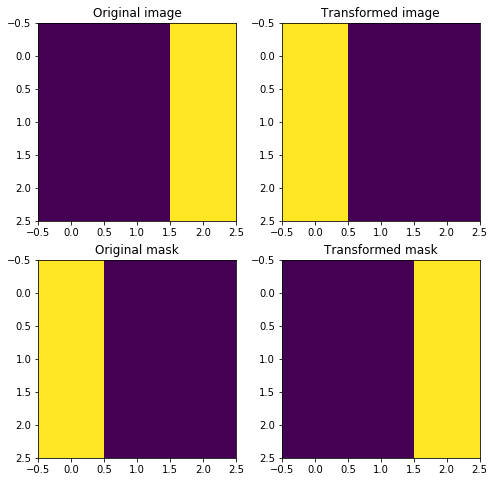

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].set_title('Original image')
ax[0, 0].imshow(test_img_4.squeeze())

ax[0, 1].set_title('Transformed image')
ax[0, 1].imshow(img_res.squeeze())

ax[1, 0].set_title('Original mask')
ax[1, 0].imshow(test_mask_4)

ax[1, 1].set_title('Transformed mask')
ax[1, 1].imshow(mask_res)
plt.show()

## Serializing transforms into `dict`, `yaml` or `json`

We found serialization of the augmentation pipelines to be an important challenge when running experiements. In `SOLT`, we developed the API that allows you to conveniently serialize the whole transformation stream into `dict`, `yaml` or `json`:

In [18]:
stream = slc.Stream([
    slt.Flip(axis=1),
    slt.Rotate(angle_range=(-90, 90)),
])
stream.to_dict()  # this converts the pipeline into a dict

{'optimize_stack': False,
 'interpolation': None,
 'padding': None,
 'transforms': [{'flip': {'p': 0.5, 'data_indices': None, 'axis': 1}},
  {'rotate': {'p': 0.5,
    'padding': ('z', 'inherit'),
    'interpolation': ('bilinear', 'inherit'),
    'ignore_state': True,
    'angle_range': (-90, 90)}}]}

In [19]:
print(stream.to_json())  # to json

{
    "stream": {
        "optimize_stack": false,
        "interpolation": null,
        "padding": null,
        "transforms": [
            {
                "flip": {
                    "p": 0.5,
                    "data_indices": null,
                    "axis": 1
                }
            },
            {
                "rotate": {
                    "p": 0.5,
                    "padding": [
                        "z",
                        "inherit"
                    ],
                    "interpolation": [
                        "bilinear",
                        "inherit"
                    ],
                    "ignore_state": true,
                    "angle_range": [
                        -90,
                        90
                    ]
                }
            }
        ]
    }
}


In [20]:
print(stream.to_yaml())

stream:
  interpolation: null
  optimize_stack: false
  padding: null
  transforms:
  - flip:
      axis: 1
      data_indices: null
      p: 0.5
  - rotate:
      angle_range:
      - -90
      - 90
      ignore_state: true
      interpolation:
      - bilinear
      - inherit
      p: 0.5
      padding:
      - z
      - inherit



## Extending with own transforms
Let's implement a simple transform that randomly zeroes one of the image corners. All transforms must be inherited from `slb.ImageTransform` or `slb.BaseTransform`. In this case, you do not need to worry about how to read and write the data from DataContainer, how to do serialization, etc. To fully understand the implementation details, please, follow the docstrings:

In [21]:
class ImageCornerDropTransform(slb.ImageTransform):
    
    serializable_name = 'corner_drop'
    
    def __init__(self, corner_size=None, p=None, data_indices=None):
        """Transform, which simply drops one of the image corners.
        
        
        Here is the order of corners used:
        
        01
        23
        
        Because this transform is only for images, let's use a parent class `ImageTransform` from
        the module `base_transforms`.
        
        p : None or float
            Probability of using this transform.
        data_indicies : tuple or None
            Indices within a data container where this transform need to be applied. 
        """
        super(ImageCornerDropTransform, self).__init__(p=p, data_indices=data_indices)
        if corner_size is None:
            corner_size = 0
        self.corner_size = corner_size
        
    def sample_transform(self):
        """This method samples the parameters of the transform.
        
        Having called this method once we can easily apply the same transformation to 
        every item within a data container. 
        
        """
        self.state_dict['corner'] = np.random.randint(0, 4)
        
    def _apply_img(self, img, item_settings):
        """Applies a transform to an image.
        
        Every transform has the following set of methods, which are applied autimatically, depending on the data:
        _apply_img
        _apply_mask
        _apply_labels
        _apply_pts
        
        Because this particular transform is a subclass of ImageTransform, then we just need to define the behavior for images.
        
        """
        img = img.copy()
        s = self.corner_size
        if self.state_dict['corner'] == 0:
            img[:s, :s] = 0
        elif self.state_dict['corner'] == 1:
            img[:s, -s:] = 0
        elif self.state_dict['corner'] == 2:
            img[-s:, :s] = 0
        elif self.state_dict['corner'] == 3:
            img[-s:, -s:] = 0
            
        return img

We are not going to write any tests or do parameter checks for the transform here. To learn how this can be done, please, see the source code or the contributing guidelines.

Once the transform is implemented, it can be used right away. Let's create some data and apply this transform to it:

In [22]:
test_img = np.zeros((10, 10, 1))
test_img[:2, :2] = 1
test_img[:2, -2:] = 1
test_img[-2:, :2] = 1
test_img[-2:, -2:] = 1

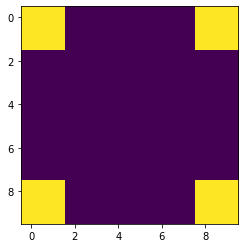

In [23]:
plt.imshow(test_img.squeeze())
plt.show()

Applying transform to drop at least 1 corner:

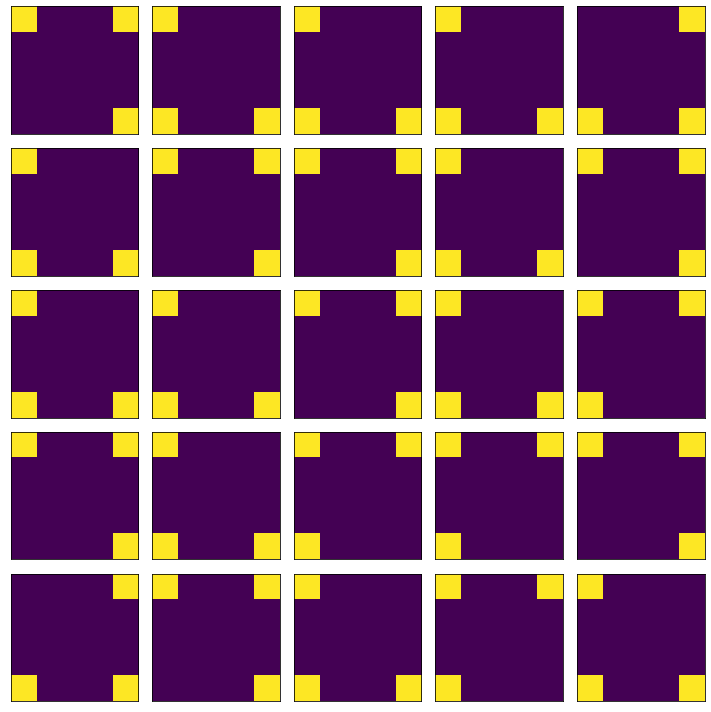

In [24]:
trf = slc.Stream([ImageCornerDropTransform(p=1, corner_size=2)])

fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for row in range(5):
    for col in range(5):
        dc_res = trf({'image': test_img}, return_torch=False)
        ax[row, col].imshow(dc_res.data[0].squeeze())
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
plt.tight_layout()
plt.show()

### More details about serialization

`SOLT` is using a pattern `registry` for serialization. Whenever a transform is inherited from `slb.BaseTransform` or `slc.Stream`, it gets added to the registry that tracks all the available transformations. It is quite easy to see what is stored in the registry:

In [25]:
slc.Stream.registry

{'stream': solt.core._core.Stream,
 'flip': solt.transforms._transforms.Flip,
 'rotate': solt.transforms._transforms.Rotate,
 'rotate_90': solt.transforms._transforms.Rotate90,
 'shear': solt.transforms._transforms.Shear,
 'scale': solt.transforms._transforms.Scale,
 'translate': solt.transforms._transforms.Translate,
 'projection': solt.transforms._transforms.Projection,
 'pad': solt.transforms._transforms.Pad,
 'resize': solt.transforms._transforms.Resize,
 'crop': solt.transforms._transforms.Crop,
 'noise': solt.transforms._transforms.Noise,
 'cutout': solt.transforms._transforms.CutOut,
 'salt_and_pepper': solt.transforms._transforms.SaltAndPepper,
 'gamma_correction': solt.transforms._transforms.GammaCorrection,
 'contrast': solt.transforms._transforms.Contrast,
 'blur': solt.transforms._transforms.Blur,
 'hsv': solt.transforms._transforms.HSV,
 'brightness': solt.transforms._transforms.Brightness,
 'cvt_color': solt.transforms._transforms.CvtColor,
 'keypoints_jitter': solt.trans

It can be seen that `corner_drop` has been added to the registry, which means we can also deserialize it later:

In [26]:
yaml_str = """
stream:
    transforms:
    - rotate_90:
        k: 2
    - corner_drop:
        corner_size: 2
        p: 1
"""

In [27]:
deserialized = slu.from_yaml(yaml_str)

Let's check how the deserialized transform works:

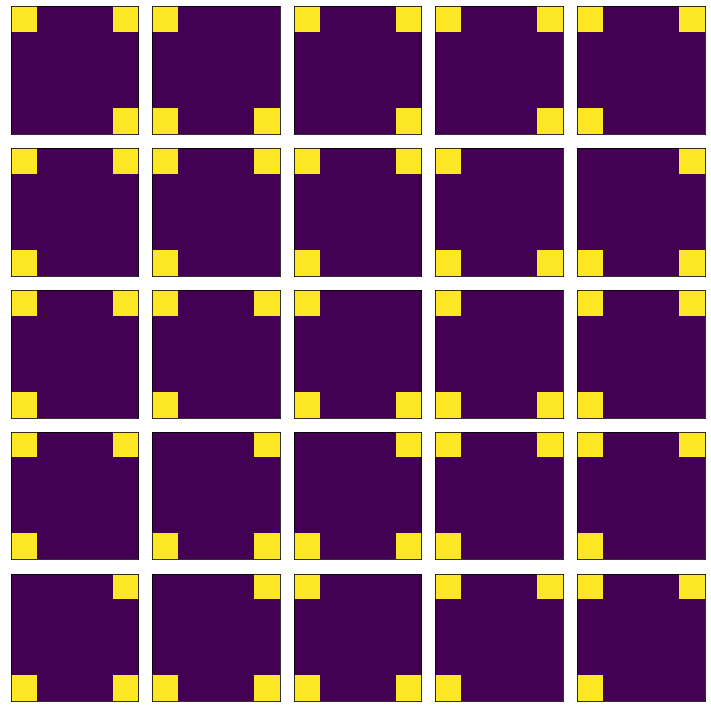

In [28]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for row in range(5):
    for col in range(5):
        dc_res = deserialized({'image': test_img}, return_torch=False)
        ax[row, col].imshow(dc_res.data[0].squeeze())
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
plt.tight_layout()
plt.show()